<a href="https://colab.research.google.com/github/ahmadusmani12/Tutorials/blob/master/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ModuleNotFoundError: ignored

In [3]:
!conda install -c memex pyldavis


/bin/bash: conda: command not found


In [4]:
!pip install -c memex pyldavis


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'memex'


In [5]:
imUsingColab = False

if imUsingColab:
    !pip install gensim
    !pip install pyLDAvis
    !pip install vega
    !pip install altair

In [6]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

import pyLDAvis.gensim

ModuleNotFoundError: ignored

In [7]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.5MB/s 
     |████████████████████████████████| 552kB 64kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=0f482e67459b5902b5ae96e68b332512ea3ded1d7fa745f4b480308943a82492
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=f7db990b7a5a71c5615cf8ae1be7501dafef942bf36b805765daba768bf3689b
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [8]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
df = pd.read_json('/content/sample_data/Appliances_5.json', lines=True)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something that will keep house warmer in winter. I sanded it and then painted it the same color as the house. Looks great.,Great product,1377129600,NaN,NaN
1,5,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN
2,5,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN
3,5,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN
4,5,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN


In [24]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

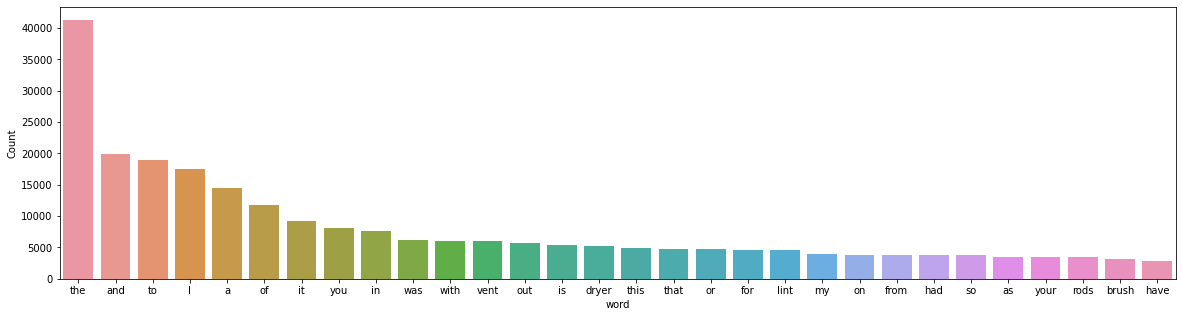

In [25]:
freq_words(df['reviewText'])

In [26]:
# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [27]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [28]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [29]:
!python -m spacy download en # one time run

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [30]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [31]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['good', 'item']


In [32]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['good', 'item']


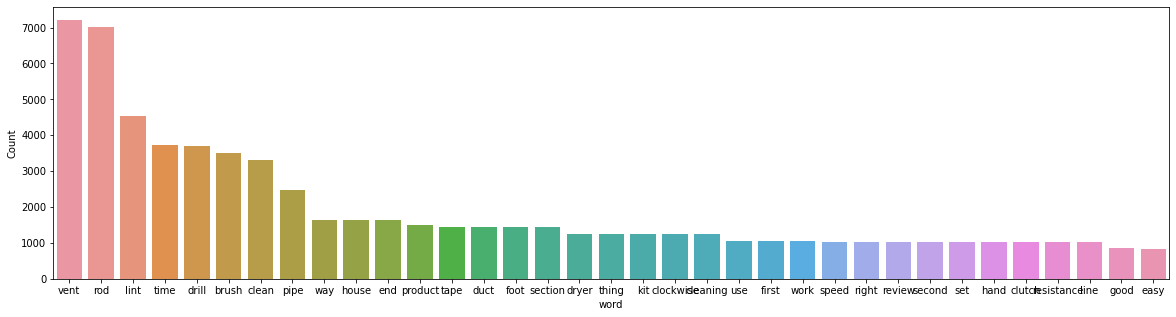

In [33]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [34]:
dictionary = corpora.Dictionary(reviews_2)

In [35]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]


In [36]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

In [37]:
lda_model.print_topics()

[(0,
  '0.104*"rod" + 0.039*"time" + 0.033*"drill" + 0.033*"lint" + 0.022*"brush" + 0.022*"tape" + 0.022*"resistance" + 0.017*"start" + 0.017*"way" + 0.016*"clockwise"'),
 (1,
  '0.024*"part" + 0.022*"year" + 0.021*"work" + 0.021*"new" + 0.021*"old" + 0.021*"problem" + 0.021*"last" + 0.021*"store" + 0.021*"thank" + 0.021*"much"'),
 (2,
  '0.064*"clean" + 0.048*"vent" + 0.048*"long" + 0.048*"cycle" + 0.032*"thing" + 0.032*"dry" + 0.032*"rod" + 0.032*"auto" + 0.020*"good" + 0.018*"product"'),
 (3,
  '0.042*"vent" + 0.036*"rod" + 0.031*"pipe" + 0.026*"speed" + 0.026*"drill" + 0.021*"high" + 0.021*"time" + 0.021*"clutch" + 0.021*"lint" + 0.016*"use"'),
 (4,
  '0.086*"vent" + 0.039*"brush" + 0.039*"lint" + 0.031*"clean" + 0.031*"section" + 0.024*"hand" + 0.023*"house" + 0.017*"product" + 0.016*"year" + 0.016*"little"'),
 (5,
  '0.048*"lint" + 0.048*"rod" + 0.048*"foot" + 0.036*"instruction" + 0.036*"duct" + 0.024*"low" + 0.024*"quick" + 0.024*"brush" + 0.024*"drill" + 0.024*"dryer"'),
 (6,


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.103372 -0.114086       1        1  23.156450
0      0.094769 -0.104597       2        1  21.835449
6      0.095720  0.125974       3        1  16.207209
4      0.035736  0.104773       4        1  15.299254
5      0.011141 -0.268952       5        1  10.169743
2      0.080790  0.233288       6        1   7.582430
1     -0.421529  0.023599       7        1   5.749466, topic_info=          Term         Freq        Total Category  logprob  loglift
280        rod  6961.000000  6961.000000  Default  30.0000  30.0000
299       vent  7137.000000  7137.000000  Default  29.0000  29.0000
243      clean  3280.000000  3280.000000  Default  28.0000  28.0000
308       foot  1433.000000  1433.000000  Default  27.0000  27.0000
464       line  1015.000000  1015.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
299       vent   193.379593  7137.820312   Topic7  -3.9241  -0.7524
482      handy   193.347931   398.608124   Topic7  -3.9243   2.1326
481  direction   193.347931   398.608124   Topic7  -3.9243   2.1326
341  appliance   193.340073   399.459412   Topic7  -3.9243   2.1304
437      dirty   193.338699   399.966614   Topic7  -3.9243   2.1291

[424 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
218       3  0.996443      able
429       6  0.996226   adapter
514       7  0.993321  american
167       4  0.662728     angle
167       6  0.336261     angle
...     ...       ...       ...
123       5  0.199914      work
123       7  0.203796      work
340       5  0.994932     worth
43        4  0.655696      year
43        7  0.342786      year

[496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 5, 6, 3, 2])